Library Used

In [1]:
#used for mathematical calculation 
#large calculations
import numpy as np

#used for the handling of the dataset and the dataframe
import pandas as pd

#used for visualization of the model training
import matplotlib.pyplot as plt
import seaborn as sns

#used to import the path of file or the directory
import os 

In [10]:
from keras.utils import to_categorical

#it is deep learning neural network
#it used for training large and complex dataset
from tensorflow.keras.preprocessing import image
import tensorflow as tf

#used to import the images
from PIL import Image

#used for image processing
import cv2

Data Loading

In [3]:
# Load images from files
def load_images_from_files(image_dir):
    images = []
    for filename in os.listdir(image_dir):
        # Assuming images are in JPEG or PNG format
        if filename.endswith(".jpg") or filename.endswith(".png"):  
            img_path = os.path.join(image_dir, filename)
            # Convert to RGB if image has alpha channel
            img = Image.open(img_path).convert('RGB')  
            # Resize to 32x32
            img = img.resize((32, 32)) 
             # Convert to numpy array and normalize  
            img_array = np.array(img) / 255.0 
            images.append(img_array)
    return np.array(images) 

Target Label

In [4]:
#our training set contain four labels
#these four labels are being used to classify the models
def load_labels(file_path):
    label_dict = {'Fog': 0, 'Rain': 1, 'Sand': 2, 'Snow':3}  # Map string labels to numeric labels
    num_classes = len(label_dict)  # Number of unique classes
    with open(file_path, 'r') as file:
        labels = [label_dict[label.strip()] for label in file.readlines()]
    return to_categorical(labels, num_classes)  # One-hot encode labels


Image Folder

In [5]:
image_dir = "/home/raghu/urdoer_projects/rain_weather_detection/training_dataset/merged_train_images"

Target Label

In [6]:
label_file_path = "/home/raghu/urdoer_projects/rain_weather_detection/training_dataset/imges_lables.txt"

Data seperation

In [7]:
x_train = load_images_from_files(image_dir)

In [8]:
y_train = load_labels(label_file_path) 


U-net model architecture

In [11]:
# Define U-Net model

def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    concat4 = tf.keras.layers.Concatenate()([conv2, up4])
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = tf.keras.layers.Concatenate()([conv1, up5])
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Preprocess input images
def preprocess_images(images):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (32, 32))
        resized_images.append(resized_img)
    processed_images = np.array(resized_images) / 255.0
    return processed_images.astype('float32')


# Preprocess target labels
def preprocess_labels(labels, num_classes):
    # Initialize an array to hold the preprocessed labels
    y_train_preprocessed = np.zeros((labels.shape[0], 32, 32, num_classes))
    
    # Iterate over each sample in y_train
    for i in range(labels.shape[0]):
        # Reshape each row of labels to (32, 32, num_classes)
        y_train_preprocessed[i] = np.tile(labels[i], (32, 1, 1))
    
    return y_train_preprocessed


# Example data loading and preprocessing
# Assuming x_train contains input images and y_train contains corresponding integer labels

# Load and preprocess input images
x_train_preprocessed = preprocess_images(x_train)

# Preprocess target labels
num_classes = 4  # Adjust according to the number of classes in your dataset
y_train_preprocessed = preprocess_labels(y_train, num_classes)

# Define input shape
input_shape = x_train_preprocessed.shape[1:]  # Shape of a single image

# Create U-Net model
model = unet_model(input_shape, num_classes)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_preprocessed, y_train_preprocessed, epochs=10, batch_size=16, validation_split=0.1)


2024-04-30 13:05:39.292275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-30 13:05:39.293524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (raghu): /proc/driver/nvidia/version does not exist
2024-04-30 13:05:39.297991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 13:05:39.667325: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 83595264 exceeds 10% of free system memory.
2024-04-30 13:05:39.812145: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 111460352 exceeds 10% of free system mem

Epoch 1/10
426/426 [==============================] - 443s 1s/step - loss: 1.3707 - accuracy: 0.2765 - val_loss: 1.7555 - val_accuracy: 0.0000e+00
Epoch 2/10
426/426 [==============================] - 441s 1s/step - loss: 1.3676 - accuracy: 0.2739 - val_loss: 1.8247 - val_accuracy: 0.0000e+00
Epoch 3/10
426/426 [==============================] - 443s 1s/step - loss: 1.3667 - accuracy: 0.2781 - val_loss: 1.9407 - val_accuracy: 0.0000e+00
Epoch 4/10
426/426 [==============================] - 440s 1s/step - loss: 1.3673 - accuracy: 0.2726 - val_loss: 1.8155 - val_accuracy: 0.0000e+00
Epoch 5/10
426/426 [==============================] - 442s 1s/step - loss: 1.3669 - accuracy: 0.2662 - val_loss: 1.8163 - val_accuracy: 0.0000e+00
Epoch 6/10
426/426 [==============================] - 440s 1s/step - loss: 1.3668 - accuracy: 0.2763 - val_loss: 1.7787 - val_accuracy: 0.0000e+00
Epoch 7/10
426/426 [==============================] - 441s 1s/step - loss: 1.3668 - accuracy: 0.2772 - val_loss: 1.774

In [17]:
# Get training accuracy from the history object
training_accuracy = history.history['accuracy']

# Print the training accuracy
print("Training Accuracy:", 1 - training_accuracy[-1])  # Get the last epoch's accuracy

Training Accuracy: 0.7295688390731812


In [14]:
# Save the training history
np.save('training_history.npy', history.history)


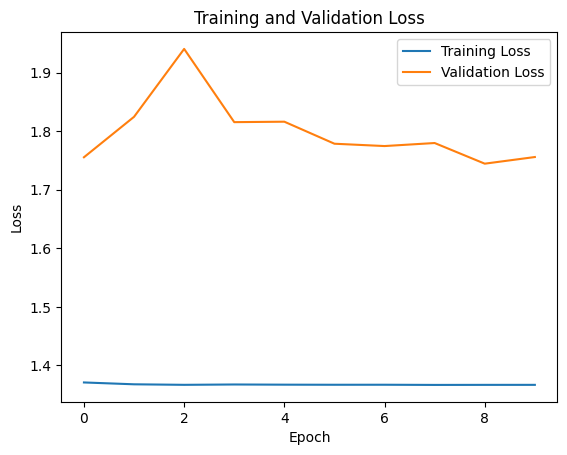

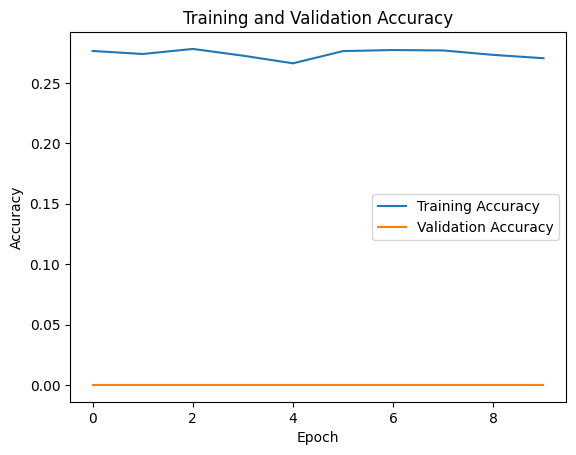

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history returned by model.fit()

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [15]:
import numpy as np

# Load the saved training history
loaded_history = np.load('training_history.npy', allow_pickle=True).item()


LNet Architecture

/tmp/ipykernel_64960/3736348962.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_preprocessed, dtype=torch.float32)  # Use float type for target labels


Epoch [1/10], Loss: 1.3869192890082556, Accuracy: 24.262468580500066%
Epoch [2/10], Loss: 1.3866223653829628, Accuracy: 24.16986373858976%
Epoch [3/10], Loss: 1.3865316304797601, Accuracy: 24.606429421881202%
Epoch [4/10], Loss: 1.3865030401604876, Accuracy: 24.103717422939543%
Epoch [5/10], Loss: 1.386484434186278, Accuracy: 24.3021563698902%
Epoch [6/10], Loss: 1.3864237080164743, Accuracy: 24.249239317370023%
Epoch [7/10], Loss: 1.38649479203698, Accuracy: 24.606429421881202%
Epoch [8/10], Loss: 1.386460875103892, Accuracy: 24.288927106760152%
Epoch [9/10], Loss: 1.3864804904506272, Accuracy: 24.103717422939543%
Epoch [10/10], Loss: 1.38649626816554, Accuracy: 23.825902897208625%


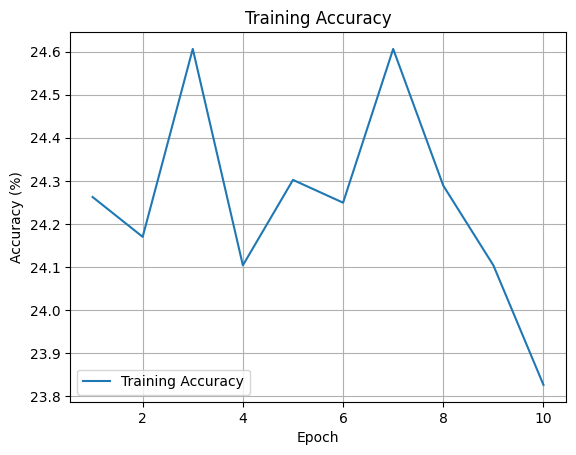

In [47]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define L-Net model in PyTorch
class LNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here
        return x

# Preprocess input images
def preprocess_images(images):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (32, 32))
        resized_images.append(resized_img)
    processed_images = np.array(resized_images) / 255.0
    return processed_images.transpose(0, 3, 1, 2)  # Convert to PyTorch format (NCHW)

# Preprocess target labels
def preprocess_labels(labels):
    return torch.tensor(labels, dtype=torch.float32)  # Ensure target labels are of type torch.float32

# Example data loading and preprocessing
# Assuming x_train contains input images and y_train contains corresponding integer labels

# Load and preprocess input images
x_train_preprocessed = preprocess_images(x_train)

# Preprocess target labels
y_train_preprocessed = preprocess_labels(y_train)

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_preprocessed).float()
y_train_tensor = torch.tensor(y_train_preprocessed, dtype=torch.float32)  # Use float type for target labels

# Create a DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize the model
model = LNet(input_shape=(3, 32, 32), num_classes=4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_accuracy_history = []  # Track training accuracy over epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.argmax(dim=1)).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_samples
    train_accuracy_history.append(epoch_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%")

# Plot the training accuracy
plt.plot(range(1, num_epochs+1), train_accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


ResNet architecture

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset

# Define ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Preprocess target labels
def preprocess_labels(labels, num_classes):
    return torch.tensor(labels, dtype=torch.long).squeeze()  # Ensure target labels are of type torch.long and squeeze to remove extra dimension

# Initialize ResNet model
num_classes = 4  # Adjust according to the number of classes in your dataset
model = CustomResNet(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.argmax(dim=1)).sum().item()
        total_samples += labels.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples * 100
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Training finished!")


Epoch [1/10], Loss: 1.4910, Accuracy: 24.94%
Epoch [2/10], Loss: 1.4457, Accuracy: 24.09%
Epoch [3/10], Loss: 1.4423, Accuracy: 25.66%
Epoch [4/10], Loss: 1.4254, Accuracy: 25.31%
Epoch [5/10], Loss: 1.4269, Accuracy: 25.74%
Epoch [6/10], Loss: 1.4282, Accuracy: 25.61%
Epoch [7/10], Loss: 1.4300, Accuracy: 24.86%
Epoch [8/10], Loss: 1.4241, Accuracy: 25.12%
Epoch [9/10], Loss: 1.4192, Accuracy: 24.99%
Epoch [10/10], Loss: 1.4188, Accuracy: 24.90%
Training finished!
